# Проект по анализу поведения пользователей мобильного приложения

## Описание проекта

**Цель проекта**

Разобраться, как ведут себя пользователи мобильного приложения. 

**Задачи проекта**
* Изучить воронку продаж. Проанализировать как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
* Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно проанализировать какой шрифт лучше.

## Описание данных

В датасете `logs_exp.csv` представлены следующие данные:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

In [38]:
# Импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
import plotly.express as px

**Выгрузка данных из датасета**

In [39]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Переименование названий столбцов**

In [41]:
data.columns = ['event_name', 'user_id', 'event_time', 'experiment_id']

data.head()

,event_name,user_id,event_time,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Проверка пропусков**

In [42]:
data.isna().sum()

event_name       0
user_id          0
event_time       0
experiment_id    0
dtype: int64

Пропуски в таблице отсутствуют

**Проверка дубликатов**

In [43]:
print('Количество дубликатов:', data.duplicated().sum())
print('Доля дубликатов в общем объеме данных:', round((data.duplicated().sum()/len(data)*100),2))

Количество дубликатов: 413
Доля дубликатов в общем объеме данных: 0.17


Количество дубликатов менее одно процента, соответственно они не повлияют на общий результат исследования и их можно удалить

In [44]:
data = data.drop_duplicates()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     243713 non-null  object
 1   user_id        243713 non-null  int64 
 2   event_time     243713 non-null  int64 
 3   experiment_id  243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


**Преобразование типов данных**

Тип данных в cтолбце `event_time` - `int64`, преобразуем его в `date_time`

In [45]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

data.head()

,event_name,user_id,event_time,experiment_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавим отдельный столбец `event_date` с датой

In [46]:
data['event_date'] = pd.to_datetime(data['event_time'].dt.date)

data.head()

,event_name,user_id,event_time,experiment_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Переименование названий групп в столбце `experiment_id`**

Для удобства переименуем номера групп эксперимента на А1, А2, В

In [47]:
# Переименование группы 246 на А1
data['experiment_id'] = data['experiment_id'].replace(246, 'A1')

# Переименование группы 247 на А2
data['experiment_id'] = data['experiment_id'].replace(247, 'A2')

# Переименование группы 248 на B
data['experiment_id'] = data['experiment_id'].replace(248, 'B')

data['experiment_id'].unique()

array(['A1', 'B', 'A2'], dtype=object)

Вывод:
* Пропуски в данных отсутствуют
* Удалены дубликаты в данных в количестве 413, что составляет 0.17% от общего объема данных.
* Переименованы названия столбцов на `event_time`, `user_id`, `experiment_id`
* Преобразован формат данных в столбце `event_time` на `date_time`
* Добавлен столбец `event_date` с датой 
* Переименованы для удобства номера групп экспериментов на A1, A2, B

## Исследовательский анализ данных

**Вычисления общего количества событий**

In [48]:
# Вычисление количества по типам событий
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [49]:
# Вычисление общего числа событий
events_count = len(data['event_name'])
print('Общее количество событий:', events_count)

Общее количество событий: 243713


**Вычисление общего количества пользователей**

In [50]:
users_count = data['user_id'].nunique()
print('Количество уникальных пользователей:', users_count)

Количество уникальных пользователей: 7551


**Вычисление среднего количества событий на оного пользователя**

In [51]:
print('Среднее количество событий на одного пользователя:', round(len(data['event_name'])/data['user_id'].nunique()))

Среднее количество событий на одного пользователя: 32


**Анализ периода данных**

* Определим максимальную и минимальную дату. 
* Построим гистограмму по дате и времени. 
* Определим, являются ли данные одинаково полными за весь период. 
* Определим, с какого момента данные полные и отбросим более старые. 
* Определим период времени за который располагаем данными на самом деле.

In [52]:
print('Минимальная дата:', min(data['event_date']))
print('Максимальная дата:', max(data['event_date']))
print('Данные представлены за период:', (max(data['event_date'])-min(data['event_date'])).days, 'дней')

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00
Данные представлены за период: 13 дней


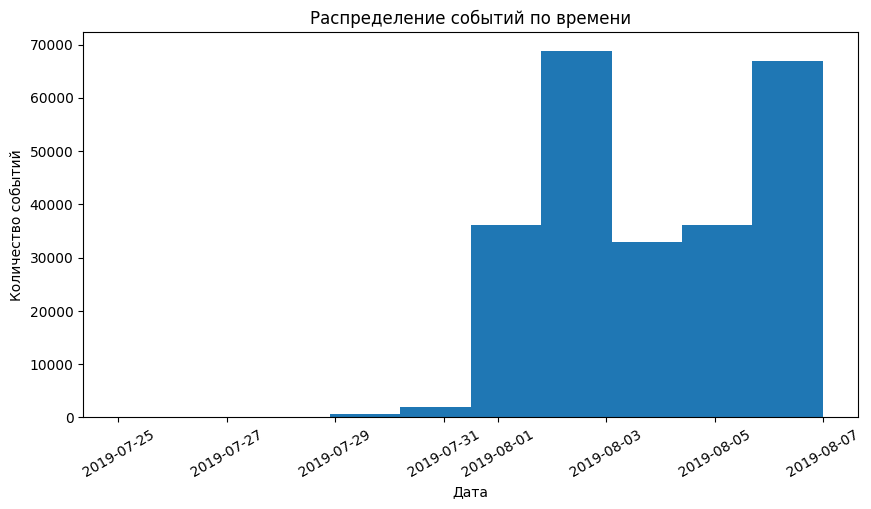

In [53]:
data['event_date'].hist(figsize=(10, 5))
plt.grid()
plt.title('Распределение событий по времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.show();

По гистограмме можно сделать вывод что релевантные данные представлены за период с 01 августа 2019г. по 07 августа 2019г, за 7 дней. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные», может сказаться разница в часовых поясах, а также что событие пользователя "растянуто" по времени. 
Для дальнейшего анализа возьмем период с 01 августа и уберем данные до этого периода.

In [54]:
# исключим из таблицы данные до 01 августа
data = data.query('event_date >= "2019-08-01"')

print('Минимальная дата:', min(data['event_date']))
print('Максимальная дата:', max(data['event_date']))

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-07 00:00:00


**Вычислим сколько осталось событий и пользователей после изменения периода**

In [55]:
# вычисление количества событий
new_events_count = len(data['event_name'])
print('Новое количество событий:', new_events_count)
print('Количество событий уменьшилось на', events_count - new_events_count, ',',
       round((events_count - new_events_count)/events_count*100, 2), '%')

Новое количество событий: 240887
Количество событий уменьшилось на 2826 , 1.16 %


In [56]:
# вычисление количества пользователей
new_users_count = data['user_id'].nunique()
print('Новое количество пользователей:', new_users_count)
print('Количество пользователей уменьшилось на', users_count - new_users_count, ',',
       round((users_count - new_users_count)/users_count*100, 2), '%')

Новое количество пользователей: 7534
Количество пользователей уменьшилось на 17 , 0.23 %


Количество удаленных данных составляет незначительную часть от общего объема, что не окажет существенного влияния на дальнейшее исследование

**Проверим наличие и количество пользователей во всех группах**

In [57]:
data.groupby('experiment_id').agg({'user_id': 'nunique'})

,user_id
experiment_id,
A1,2484
A2,2513
B,2537


Во всех группах примерно одинаковое количество пользователей.

## Анализ воронки событий

**Анализ событий**

In [58]:
data['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В логе встречается 5 видов событий. Преобладает `MainScreenAppear` - 117328, меньше всего встречается событие `Tutorial` - 1005 

**Анализ количества пользователей по событиям**

In [59]:
# подсчет количества пользователей по событиям
events_by_users = (data.groupby('event_name').agg({'user_id': 'nunique'})
                   .sort_values('user_id', ascending=False).reset_index())
events_by_users

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [60]:
# расчет количества доли пользователей от общего числа по событиям
events_by_users['users_share'] = round(events_by_users['user_id'] / data['user_id'].nunique() * 100, 2)

events_by_users

,event_name,user_id,users_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Последовательность событий выглядит следующим образом:
* 98,47% пользователей попадают на главный экран
* 60,96% пользователей попадают на экран с предложением
* 49,56% пользователей переходят на экран оплаты
* 46,97% пользователей производят оплату

Событие "Обучение" появляется у 11,15%. Учитывая столь низкий процент можно предположить, что обучение не является обязательным для пользователей, а также большая часть пользователей может обойтись без него. Соответственно данное событие можно исключить из цепочки событий.

**Проанализируем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).**

In [61]:
# Исключим событие Tutorial из воронки
data = data[data['event_name'] != 'Tutorial']
events_ratio = (data.groupby('event_name').agg({'user_id': 'nunique'})
                .sort_values('user_id', ascending=False).reset_index())
events_ratio

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [62]:
# Добавим столбец с расчетом долей пользователей, которая переходит на следующий шаг воронки
events_ratio['conversion'] = ''

for i in range(0, len(events_ratio)):
    if i==0:
        events_ratio.loc[i, 'conversion'] = 100
    else:
        events_ratio.loc[i, 'conversion'] = (round(events_ratio.loc[i, 'user_id'] 
                                             / events_ratio.loc[i-1, 'user_id']*100,2))

events_ratio

,event_name,user_id,conversion
0,MainScreenAppear,7419,100
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.3
3,PaymentScreenSuccessful,3539,94.78


Больше всего теряется пользователей на первом шаге, 38% пользователей не доходит до страницы с предложением. Нужно проанализировать причину.

**Проанализируем, какая доля пользователей доходит от первого события до оплаты.**

Построим общую воронку с конверсией

In [63]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = events_ratio['event_name'],
    x = events_ratio['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial", 
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]})
    )

fig.update_layout(title="Воронка конверсии пользователей по событиям")

fig.show()

In [64]:
print('От первого события до оплаты доходит', round(events_ratio.loc[3, 'user_id'] / events_ratio.loc[0, 'user_id']*100,2),'% пользователей')

От первого события до оплаты доходит 47.7 % пользователей


## Анализ результатов эксперимента

**Проанализируем сколько пользователей в каждой группе**

In [65]:
data.groupby('experiment_id').agg({'user_id': 'nunique'})

,user_id
experiment_id,
A1,2483
A2,2512
B,2535


Проверим группы на совпадение пользователей

In [66]:
data.groupby('user_id').agg({'experiment_id':'nunique'}).query('experiment_id > 1') 

,experiment_id
user_id,


Пользователи в группах не пересекаются

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проанализируем, находят ли статистические критерии разницу между выборками A1 и A2.**

Выберем самое популярное событие `MainScreenAppear` и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп.

In [67]:
users_by_groups = (data.query('event_name=="MainScreenAppear" and (experiment_id=="A1" or experiment_id=="A2")')
                   .groupby('experiment_id').agg({'user_id':'nunique'}).reset_index())
users_by_groups

,experiment_id,user_id
0,A1,2450
1,A2,2476


Проанализируем какая доля пользователей совершила каждое событие

In [68]:
a1_total = data.query('experiment_id == "A1"')['user_id'].nunique()
a2_total = data.query('experiment_id == "A2"')['user_id'].nunique()

users_by_groups.loc[0, 'users_share'] = round(users_by_groups.loc[0, 'user_id']/a1_total*100,2)
users_by_groups.loc[1, 'users_share'] = round(users_by_groups.loc[1, 'user_id']/a2_total*100,2)

users_by_groups

,experiment_id,user_id,users_share
0,A1,2450,98.67
1,A2,2476,98.57


**Проанализируем, будет ли отличие между группами статистически достоверным по всем событиям**

Для дальнейшего анализа сформулируем гипотезы:
* Нулевая гипотеза: между долями групп нет разницы
* Альтернативная гипотеза: между долями групп существует значительная разница

In [69]:
# Функция для проведения тестов

def test_func(group1, group2, event, alpha):
    
    def successes_trials(group1, group2, event):
        successes = np.array([data.query(f'experiment_id == "{group1}" & event_name == "{event}"')['user_id'].nunique(),\
                          data.query(f'experiment_id == "{group2}" & event_name == "{event}"')['user_id'].nunique()])

        trials = np.array([data.query(f'experiment_id == "{group1}"')['user_id'].nunique(),\
                           data.query(f'experiment_id == "{group2}"')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Результаты теста для групп {group1} и {group2} по событию {event}')
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [70]:
test_func('A1', 'A2', 'MainScreenAppear', 0.05)

Результаты теста для групп A1 и A2 по событию MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [71]:
test_func('A1', 'A2', 'OffersScreenAppear', 0.05)

Результаты теста для групп A1 и A2 по событию OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [72]:
test_func('A1', 'A2', 'CartScreenAppear', 0.05)

Результаты теста для групп A1 и A2 по событию CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [73]:
test_func('A1', 'A2', 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп A1 и A2 по событию PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании результатов тестов можно сделать вывод, что между группами А1 и А2 отсутствует статистически значимое различие

**Сравним группу В с изменённым шрифтом с каждой из контрольных групп (А1, А2) в отдельности по каждому событию.**

**Сравним группы А1 и В**

In [74]:
test_func('A1', 'B', 'MainScreenAppear', 0.05)

Результаты теста для групп A1 и B по событию MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [75]:
test_func('A1', 'B', 'OffersScreenAppear', 0.05)

Результаты теста для групп A1 и B по событию OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [76]:
test_func('A1', 'B', 'CartScreenAppear', 0.05)

Результаты теста для групп A1 и B по событию CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [77]:
test_func('A1', 'B', 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп A1 и B по событию PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании результатов тестов можно сделать вывод, что между группами А1 и В отсутствует статистически значимое различие

**Сравним группы А2 и В**

In [78]:
test_func('A2', 'B', 'MainScreenAppear', 0.05)

Результаты теста для групп A2 и B по событию MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [79]:
test_func('A2', 'B', 'OffersScreenAppear', 0.05)

Результаты теста для групп A2 и B по событию OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [80]:
test_func('A2', 'B', 'CartScreenAppear', 0.05)

Результаты теста для групп A2 и B по событию CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [81]:
test_func('A2', 'B', 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп A2 и B по событию PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании результатов тестов можно сделать вывод, что между группами А2 и B отсутствует статистически значимое различие

**Сравним объединенную контрольную группу (A1,A2) с группой В**

In [82]:
# Объединим группы А1 и А2 в одну группу А
data['experiment_id'] = data['experiment_id'].replace('A1', 'A')
data['experiment_id'] = data['experiment_id'].replace('A2', 'A')

In [83]:
test_func('A', 'B', 'MainScreenAppear', 0.05)

Результаты теста для групп A и B по событию MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [84]:
test_func('A', 'B', 'OffersScreenAppear', 0.05)

Результаты теста для групп A и B по событию OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [85]:
test_func('A', 'B', 'CartScreenAppear', 0.05)

Результаты теста для групп A и B по событию CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [86]:
test_func('A', 'B', 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп A и B по событию PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании результатов тестов можно сделать вывод, что между объединенными группами А1,А2 и В отсутствует статистически значимое различие. Соответственно изменение шрифтов в приложении не оказало влияние на поведение пользователей.

Для анализа был выбран коэффициент значимости 0.05. Всего было проведено 16 проверок статистических гипотез. При всех проверках нулевая гипотеза не отвергается, соответственно использование коэффициента 0.01 не имеет смысла, т.к. результат тестов останется прежним.

## Выводы

В рамках проекта были сделаны следующие выводы:
* Данные в логе предоставлены с 25 июля 2019 по 07 августа 2019. Однако для анализа был выбран период с 01 по 08 августа 2019, так как за июль не было значительной активности среди пользователей по сравнению с августом и столь значительная разница может «перекашивать данные». В результате были удалены 1.16% событий и 0.23%, что не является значимым и не окажет влияния на общие результаты исследования.

* Общее количество событий: 243713. Количество уникальных пользователей: 7551. Среднее количество событий на одного пользователя: 32

* В логе встречается 5 видов событий. Преобладает `MainScreenAppear` - 117328, количетсво пользователей его совершивших - 7419 (98,47% от общего числа), меньше всего встречается событие `Tutorial` - 1005, количество пользователей - 840 (11,5% от общего числа). Учитывая количество событий и количество пользователей `Tutorial` было исключено из дальнейшего анализа как малозначимое, а также не входящее в воронку продаж.

* Воронка продаж выглядит следующим образом: 
	
    1. `MainScreenAppear`	    	100
    2. `OffersScreenAppear`    	61.91
    3. `CartScreenAppear`	    	81.3
    4. PaymentScreenSuccessful	94.78

* Больше всего теряется пользователей на первом шаге, 38% пользователей не доходит до страницы с предложением. Нужно дополнительно проанализировать причину. От первого события до оплаты доходит 47.7 % пользователей.

* Размер групп пользователе для A/A/B-эксперимента совпадает

* Было проведено 16 экспериментов для проверок статистических гипотез между группами A1 и A2, A1 и В, A2 и B, объединенной группы А и B. Коэффициент статистической значимости 0.05. В результате всех экспериментов значимой статистической разницы между группами не выявлено. Следовательно можно сделать вывод, что изменение шрифтов в приложении не повлияло на поведение пользователей.